Identify glacier segments that have large water amounts, and investigate the slope

In [226]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [227]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [228]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [229]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

### We're going to divide the each glacier into 500 m segments and calculate average slope and average water cover of that segment

In [230]:
# open the water by distance data for each glacier, format into a single df
c=0
df_all_area = []
df_all_norm_area = []
df_all_percent = []
df_all_norm_percent = []

years_to_use = [2019,2020,2021,2022,2023]
bin_size = 200
df_final = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>100: continue
    
    rgi_id = row['rgi_id']
    # o1region = row['o1region']
    # o2region = row['o2region']
    # o3region = row['o3region']
    
    # if rgi_id!='RGI2000-v7.0-G-15-08331':continue
    
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier water cover info  
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water',
                             'annual_water_distances_binary_otsuoptimal_188_accaqa.csv')
    df_g = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    
    # rename columns
    old_cols = df_g.columns.values[1:]
    new_cols = [ int(i.split("_")[0]) for i in old_cols ]
    df_g = df_g.rename(dict(zip(old_cols, new_cols)), axis=1)
    
    # extract just the 2019-2023 period
    df_g = df_g[df_g['year'].isin(years_to_use)].set_index('year')
    
    
    # open debris-covered area along glacier
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'debris_area_by_distance.csv')
    df_dca = pd.read_csv(path_open, index_col='band', header=0).squeeze().drop("Unnamed: 0", axis=1).T
    old_cols = df_dca.columns.values
    new_cols = [ int(i.split("_")[0]) for i in old_cols ]
    df_dca = df_dca.rename(dict(zip(old_cols, new_cols)), axis=1)
    
    
    # open slope along glacier
    path_open = os.path.join(folder_glaciers, rgi_id,  'Base Products', 'glacier_slopes.csv')
    df_slope = pd.read_csv(path_open, index_col=None, header=0).squeeze()

    
    # for 500 meter rolling bins, compute total sgl area, percent sgl area
    bins = np.arange(0, np.nanmax(df_g.columns)+bin_size, bin_size)
    
    bmins=[]
    bmaxs=[]
    sgls=[]
    dcas=[]
    zs=[]
    ss=[]
    for i in range(len(bins)-1):
        # if i>0: continue
        # grab bin extents
        bmin = bins[i]
        bmax = bins[i+1]
        bin_cols = [ i for i in df_g.columns if ((i>=bmin) and (i<bmax)) ]
    
        # subset to this data, water
        df_g_bin = df_g[bin_cols]
        df_dc_bin = df_dca[bin_cols]
        
        # sum across each year and then take median
        sgl_bin = df_g_bin.sum(axis=1).median()
        
        # also get total sgl area in this bin
        dca_bin = df_dc_bin.sum(axis=1).values[0]
        
        # save these values
        bmins.append(bmin)
        bmaxs.append(bmax)
        sgls.append(sgl_bin)
        dcas.append(dca_bin)
        
        # subset slopes to this bin, get median values
        slope_bin = df_slope[ (df_slope['distance']>=bmin) & (df_slope['distance']<bmax) ].median()
        zs.append(round(slope_bin['z_smooth']))
        ss.append(slope_bin['slope'])
    
    # format to df
    df_g_results = pd.DataFrame({'bmin':bmins, 'bmax':bmaxs, 'sgl_m2':sgls, 'dca_m2':dcas, 'z':zs, 'slope':ss})
    
    # add rgiid, year
    df_g_results['sgl_p'] = df_g_results['sgl_m2'] / df_g_results['dca_m2']
    df_g_results['rgi_id'] = rgi_id
    df_g_results['years'] = f"{min(years_to_use)}_{max(years_to_use)}"
    
    df_final.append(df_g_results)

df_final = pd.concat(df_final)
print("Done!")
    

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
Done!


In [231]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values

In [265]:
df_nlt = df_final[~df_final['rgi_id'].isin(rgi_lake_term)]

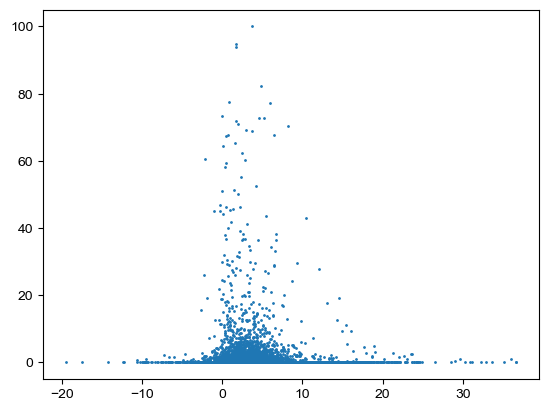

In [233]:
fig,axs = plt.subplots()
axs.scatter(df_nlt['slope'], df_nlt['sgl_p']*100, s=1)
# axs.set_yscale('log')
# axs.set_xscale('log')

Median Slope, no water: 5.009247535928395
Median Slope, 10% water: 2.4982128290329957
75% Slope, 10% water: 4.323204037300705


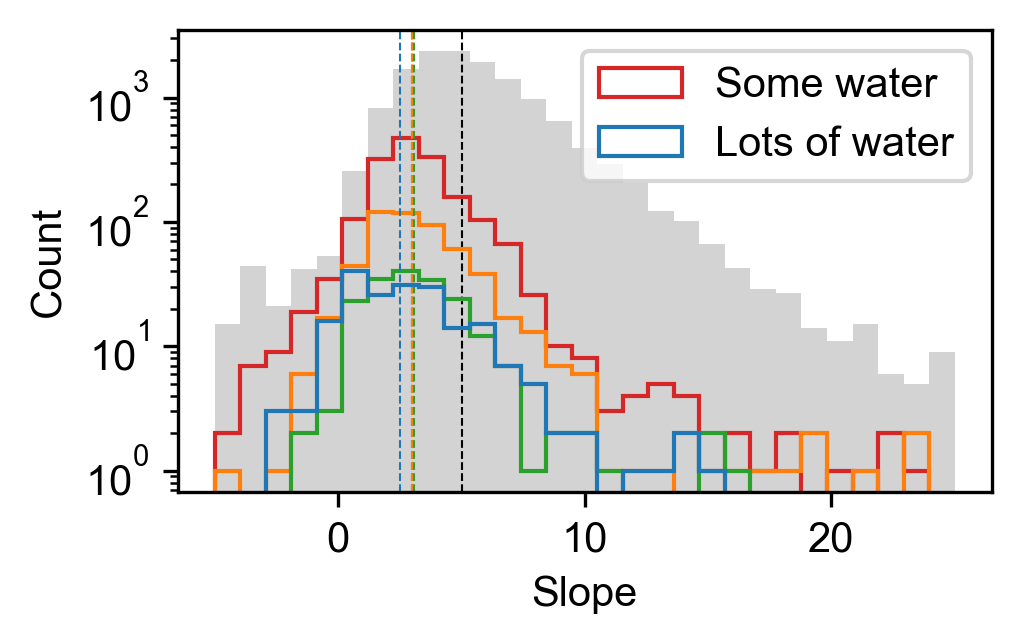

In [271]:
# lets compare the histogram of slopes for segments that have sgls vs dont
bins = np.linspace(-5,25,30)
den = False
ts = [0, 0.02, 0.05, 0.10, 9999]
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']
labels = ['Some water', "", "", "Lots of water"]

fig,axs=plt.subplots(figsize=(3.5,2), dpi=300)

axs.hist( df_nlt[ (df_nlt['sgl_p']==0) ]['slope'],
         bins=bins, color='lightgrey', density=den )

axs.axvline( np.nanmedian(  df_nlt[ (df_nlt['sgl_p']==0) ]['slope'] ),
                c='black', linestyle='dashed', linewidth=0.5 ) 

for i in range(len(ts)-1):
    
    axs.hist( df_nlt[ (df_nlt['sgl_p']>ts[i]) & (df_nlt['sgl_p']<=ts[i+1]) ]['slope'],
         bins=bins, color=colors[i], histtype='step', density=den, label=labels[i] )
    
    axs.axvline( np.nanmedian( df_nlt[ (df_nlt['sgl_p']>ts[i]) & (df_nlt['sgl_p']<=ts[i+1]) ]['slope'] ),
                c=colors[i], linestyle='dashed', linewidth=0.5 ) 

axs.legend()
axs.set_yscale('log')
axs.set_xlabel('Slope')
axs.set_ylabel('Count')

print("Median Slope, no water:",  np.nanmedian(  df_nlt[ df_nlt['sgl_p']==0 ]['slope'] ))
print("Median Slope, 10% water:", np.nanmedian( df_nlt[ df_nlt['sgl_p']>0.1 ]['slope'] ) )
print("75% Slope, 10% water:", np.nanpercentile( df_nlt[ df_nlt['sgl_p']>0.1 ]['slope'], 75 ) )

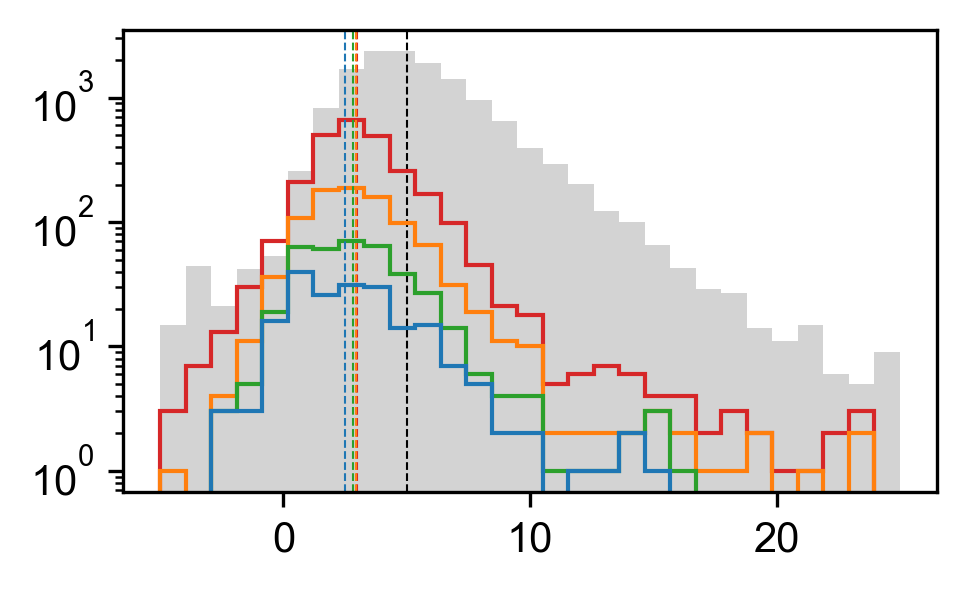

In [237]:
# lets compare the histogram of slopes for segments that have sgls vs dont
bins = np.linspace(-5,25,30)
den = False
ts = [0, 0.02, 0.05, 0.10]
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']

fig,axs=plt.subplots(figsize=(3.5,2), dpi=300)

axs.hist( df_nlt[ (df_nlt['sgl_p']==0) ]['slope'],
         bins=bins, color='lightgrey', density=den, )

axs.axvline( np.nanmedian(  df_nlt[ (df_nlt['sgl_p']==0) ]['slope'] ),
                c='black', linestyle='dashed', linewidth=0.5 ) 

for i in range(len(ts)):
    
    axs.hist( df_nlt[ (df_nlt['sgl_p']>ts[i]) ]['slope'],
         bins=bins, color=colors[i], histtype='step', density=den, )
    
    axs.axvline( np.nanmedian(df_nlt[ (df_nlt['sgl_p']>ts[i]) ]['slope'] ),
                c=colors[i], linestyle='dashed', linewidth=0.5 ) 

axs.set_yscale('log')


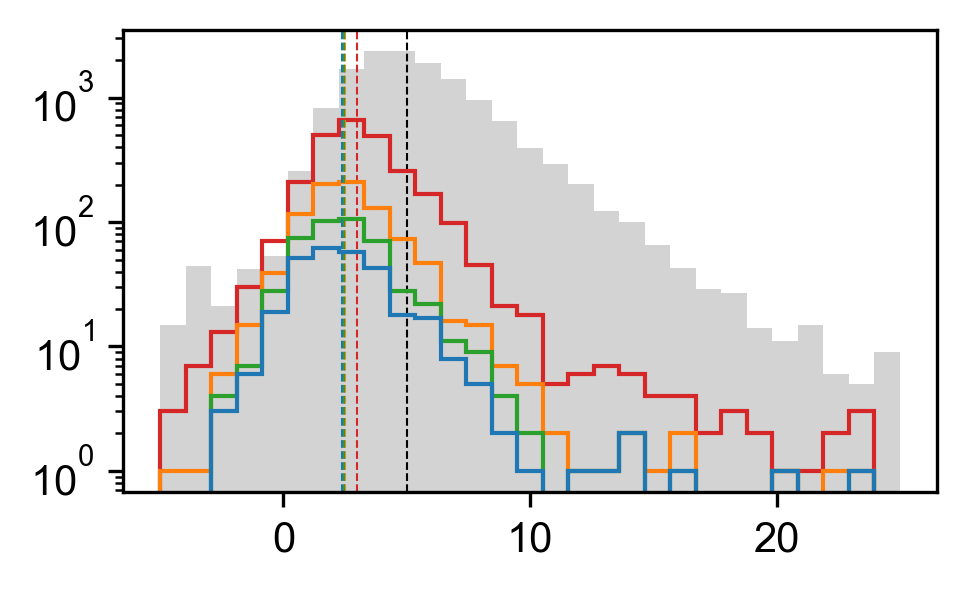

In [256]:
# lets compare the histogram of slopes for segments that have sgls vs dont
bins = np.linspace(-5,25,30)
den = False
ts = [1, 5, 9, 13]
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']

fig,axs=plt.subplots(figsize=(3.5,2), dpi=300)

axs.hist( df_nlt[ (df_nlt['sgl_m2']==0) ]['slope'],
         bins=bins, color='lightgrey', density=den, )

axs.axvline( np.nanmedian(  df_nlt[ (df_nlt['sgl_m2']==0) ]['slope'] ),
                c='black', linestyle='dashed', linewidth=0.5 ) 

for i in range(len(ts)):
    
    axs.hist( df_nlt[ ( df_nlt['sgl_m2']>=(ts[i]*900) ) ]['slope'],
         bins=bins, color=colors[i], histtype='step', density=den, )
    
    axs.axvline( np.nanmedian(df_nlt[ (df_nlt['sgl_m2']>=(ts[i]*900) ) ]['slope'] ),
                c=colors[i], linestyle='dashed', linewidth=0.5 ) 

axs.set_yscale('log')